# Creating videos tutorial

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import deeptrack as dt
from andi_datasets.models_phenom import models_phenom

/opt/anaconda3/envs/handi/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/handi/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


## 1. Single state diffusion

In [3]:
T = 10 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [4]:
trajs_model1, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=D, alphas=0.5)

## 2. Multi state diffusion

In [5]:
trajs_model2, labels_model2 = models_phenom().multi_state(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    M=np.array([[0.98, 0.02], [0.02, 0.98]]),
)

## 3. Dimerization

In [6]:
trajs_model3, labels_model3 = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

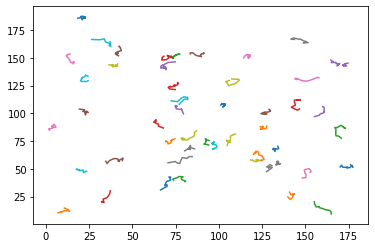

In [7]:
t3 = np.moveaxis(trajs_model3, 0, 1)
for traj in t3:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

## 4. Immobile traps

In [8]:
number_traps = 100
traps_positions = np.random.rand(number_traps, 2)*L/2 

In [9]:
trajs_model4, labels_model4 = models_phenom().immobile_traps(
    N=N,
    T=T,
    L=L,
    r=1,  # radius of the traps
    Pu=0.01,  # Unbinding probability
    Pb=1,  # Binding probability
    Ds=D,  # Diffusion coefficients of moving state
    alphas=1.6,  # Anomalous exponents of moving state
    Nt=number_traps,  # number of traps
    traps_pos=traps_positions,
)

## 5. Confinement

In [12]:
number_compartments = 100
radius_compartments = 10
compartments_center = models_phenom._distribute_circular_compartments(
    Nc=number_compartments, r=radius_compartments, L=L  # size of the environment
)

/Users/harshithbachimanchi/Desktop/Repositories/andi_datasets/tutorials/../andi_datasets/models_phenom.py:609: UserWarning: Could accomodate 55 circles of the 100 requested. Increase size of environment or decrease radius of compartments.
  warnings.warn(warn_str)


In [13]:
trajs_model5, labels_model5 = models_phenom().confinement(
    N=N,
    L=L,
    Ds=[1500 * D, 50 * D],
    comp_center=compartments_center,
    r=radius_compartments,
    trans=0.2,  # boundary transmittance
)

## 6.  Videos


For generating videos we import ``get_video_andi`` function from **andi_datasets** package

In [16]:
from andi_datasets.utils_videos import get_video_andi

### 6.1. Generating videos
The trajectory data generated through ``models_phenom()`` can be directly passed through ``get_video_andi`` function to generate fluorescence images of the particles (and the particle masks). Note that ``get_video_andi`` needs to be called with ``update()`` and ``resolve()`` methods to generate the videos and the particle masks.

The properites of the videos can be controlled by the dictionaries ``particle_props``, ``optics_props``, and ``background_props``. 

1. _particle_props_: The intensity of various particles in the final image can be controlled with ``particle_intensity``  by giving a mean intensity and standard deviation. The intensity variation of a single particle within multiple frames can be controlled by giving a standard deviation in ``intensity_variation``. Note that the intensity variation will be applied on the randomly sampled particle intensities from the first frame

2. _optics_props_: Most of the optics properties are fixed to match the experimental conditions. But they can still be modified accordingly. Please check the available properties for ``optics_props`` in **utils_videos.ipynb**

3. _background_props_: The mean background offset and the standard deviation of background within multiple frames can be controlled with ``background_mean`` and ``background_stdev``. A combination of ``particle_intensity`` and ``background_mean``can be used to tune the noise in the final image. For example., a low singal to noise ratio can be obtained by bringing the particle intensities closer to the background value

In [19]:
video, masks = get_video_andi(
    trajs_model1,

    particle_props={
        "particle_intensity": [50, 10],  # [mean, stdev]
        "intensity_variation": 5         # intensity variation
    },

    optics_props={
        "output_region": [0, 0, 200, 200], # Default region is [0, 0, 128, 128]
    },

    background_props={
        "background_mean": 10,  # Mean background
        "background_stdev": 5   # Stdev background
    }

).update().resolve()

### 6.2 Visualizing the paricles and masks in the first frame
Plotting the first frame of the video along with the particle mask

Text(0.5, 1.0, 'Mask')

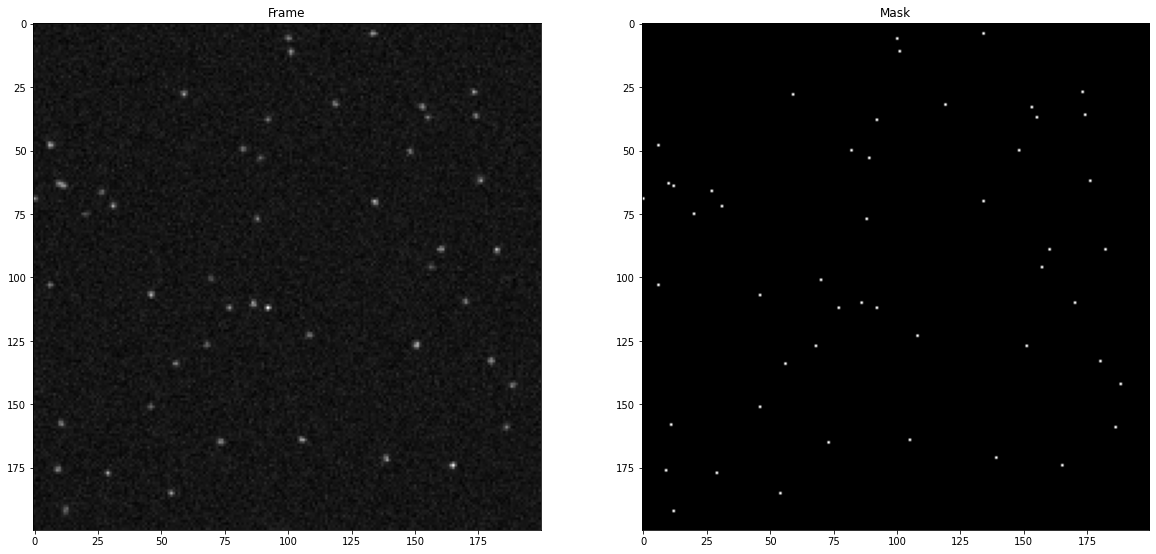

In [20]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(video[0], cmap="gray")
ax0.set_title("Frame")
ax1.imshow(masks[0], cmap="gray")
ax1.set_title("Mask")

Overlaying the particle trajectories on the first frame of the video

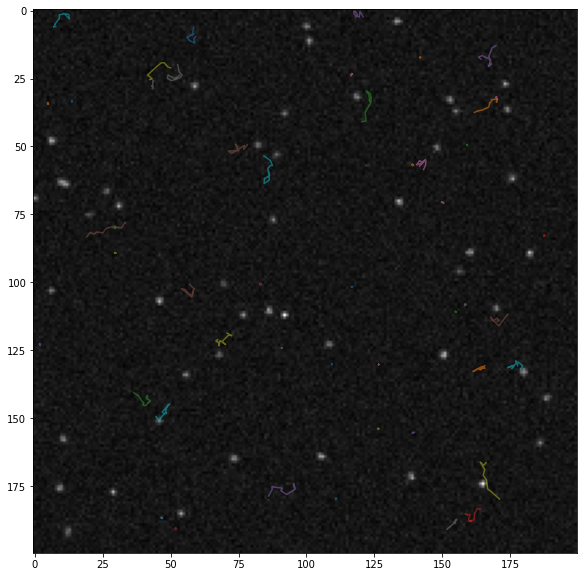

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(video[0], cmap="gray")
for traj in np.moveaxis(trajs_model2, 0, 1):
    plt.plot(traj[:,1], traj[:,0], alpha=0.5)
plt.show()

Visualzing the generated videos using ``play_video`` function

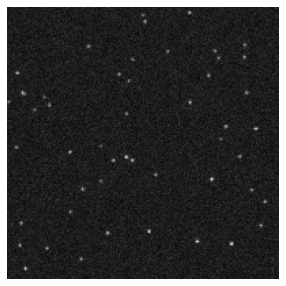

In [22]:
from andi_datasets.utils_videos import play_video
play_video(video)

### 6.2 Save the videos
Convert the video to 8bit and save it as an .MP4 file. Alternatively they can direclty be saved as numpy arrays with ``np.save(...)``

In [42]:
def convert_uint8(vid):
    new_vid = []
    for im in vid:
        im = im[:,:,0]
        im = im / im.max()
        im = im * 255
        im = im.astype(np.uint8)
        new_vid.append(im)
    return new_vid

In [44]:
# change the path accordingly
save_path = "../videos/phenom_model1.mp4"

In [45]:
video_frames_uint8 = convert_uint8(video)
imageio.mimwrite(save_path, video_frames_uint8, fps=10)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fc753254000] Warning: data is not aligned! This can lead to a speed loss
